# DATA ANALYSIS OF LA LIGA
The data used for this initial data analysis contains the information of matches ranging from season 1928/1929 to 2021/2022.

The different studies will be separated by title and brief description and the code for that specific problem.

In [502]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import os
import datetime

In [503]:
db_path = os.path.join(os.getcwd(), 'laliga.sqlite')
laliga_con = sqlite3.connect(str(db_path))
cursor = laliga_con.cursor()

### 1.  Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.

In [504]:
cursor.execute('SELECT * FROM Matches')
data = cursor.fetchall()

columns = cursor.execute('PRAGMA table_info(Matches)').fetchall()
columns = [col[1] for col in columns]

df = pd.DataFrame(data, columns=columns)
df = df[df['score'].notna()]

In [505]:
df[['goals_home', 'goals_away']] = df['score'].str.split(':', expand=True).astype(int)

In [506]:
results = [
    (df['goals_home'] > df['goals_away']),
    (df['goals_home'] == df['goals_away']),
    (df['goals_home'] < df['goals_away'])
]

df['result'] = np.select(results, ['1', 'X', '2'])

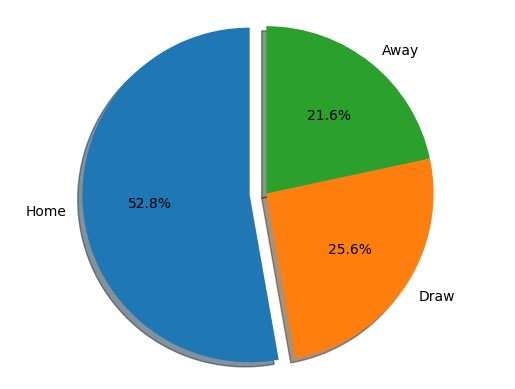

In [507]:
wins = df['result'].value_counts()

labels = ['Home', 'Draw', 'Away']
sizes = [wins['1'], wins['X'], wins['2']]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

### 2. What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division. What have been the biggest wins? Of course, when we say biggest we mean those with the highest goal difference. Show the top ten of them in a table.


In [508]:
df_1div = df.loc[df['division'] == 1].copy()
df_1div['goal_diff'] = abs(df['goals_home'] - df['goals_away'])


In [509]:
unique_teams = df_1div['home_team'].unique()

goals_dict = { team : {'scored':0, 'conceded':0} for team in unique_teams}

for team in unique_teams:
    games = 0

    df_aux = df_1div.loc[df['home_team'] == team]
    goals_dict[team]['scored'] += df_aux['goals_home'].sum()
    goals_dict[team]['conceded'] += df_aux['goals_away'].sum()
    games += df_aux.size

    df_aux = df_1div.loc[df['away_team'] == team]
    goals_dict[team]['conceded'] += df_aux['goals_home'].sum()
    goals_dict[team]['scored'] += df_aux['goals_away'].sum()
    games += df_aux.size

    goals_dict[team]['avg_scored'] = float(goals_dict[team]['scored'] / games)
    goals_dict[team]['avg_conceded'] = float(goals_dict[team]['conceded'] / games)

top_scorers = sorted(goals_dict.items(), key=lambda k_v: k_v[1]['scored'], reverse=True)[:10]
top_scorers = [[team[0], team[1]['scored']] for team in top_scorers]
top_conceders = sorted(goals_dict.items(), key=lambda k_v: k_v[1]['conceded'], reverse=True)[:10]
top_conceders = [[team[0], team[1]['conceded']] for team in top_conceders]

top_avg_scorers = sorted(goals_dict.items(), key=lambda k_v: k_v[1]['avg_scored'], reverse=True)[:10]
top_avg_scorers = [[team[0], team[1]['avg_scored']] for team in top_avg_scorers]
top_avg_conceders = sorted(goals_dict.items(), key=lambda k_v: k_v[1]['avg_conceded'], reverse=True)[:10]
top_avg_conceders = [[team[0], team[1]['avg_conceded']] for team in top_avg_conceders]

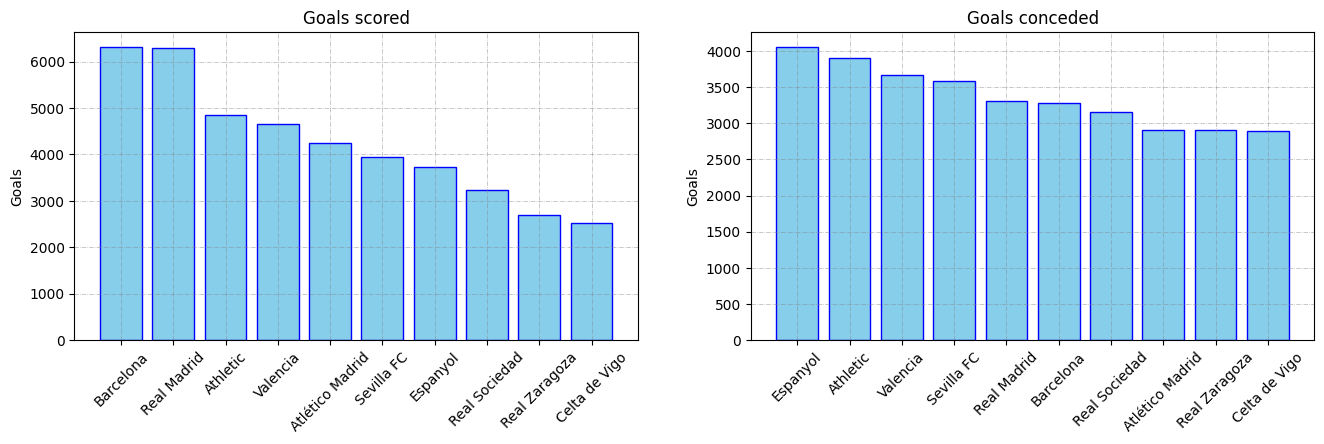

In [510]:
x = range(10)

x_labels1 = [team[0] for team in top_scorers]
x_values1 = [team[1] for team in top_scorers]

x_labels2 = [team[0] for team in top_conceders]
x_values2 = [team[1] for team in top_conceders]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.grid(visible=True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)
ax2.grid(visible=True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)

ax1.bar(x, x_values1, color='skyblue', ec='blue', lw=1)
ax1.set_title('Goals scored')
ax1.set(ylabel='Goals', xticks=x)
ax1.set_xticklabels(x_labels1, rotation=45)

ax2.bar(x, x_values2, color='skyblue', ec='blue', lw=1)
ax2.set_title('Goals conceded')
ax2.set(ylabel='Goals', xticks=x)
ax2.set_xticklabels(x_labels2, rotation=45)

plt.show()

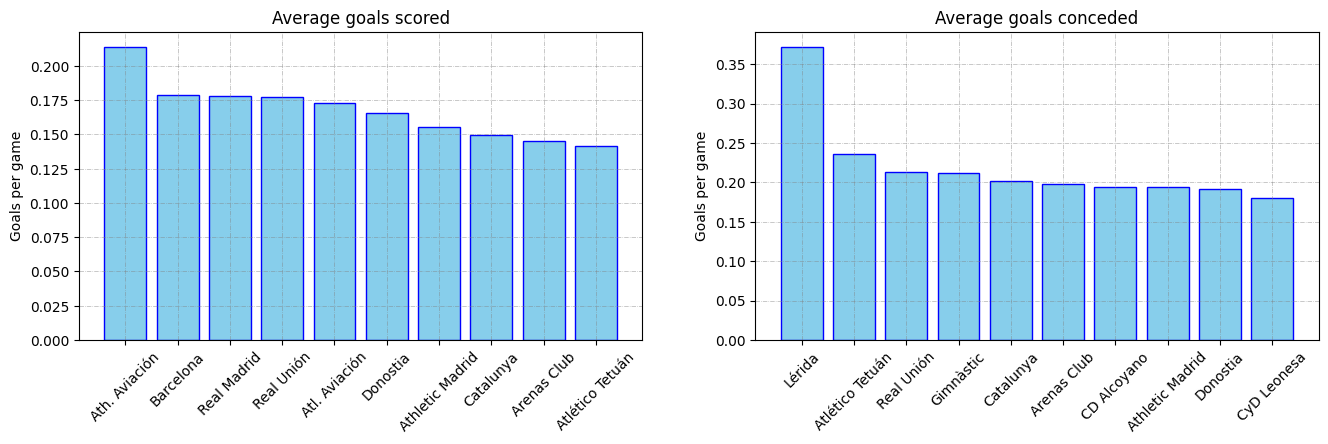

In [511]:
x = range(10)

x_labels1 = [team[0] for team in top_avg_scorers]
x_values1 = [team[1] for team in top_avg_scorers]

x_labels2 = [team[0] for team in top_avg_conceders]
x_values2 = [team[1] for team in top_avg_conceders]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.grid(visible=True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)
ax2.grid(visible=True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)

ax1.bar(x, x_values1, color='skyblue', ec='blue', lw=1)
ax1.set_title('Average goals scored')
ax1.set(ylabel='Goals per game', xticks=x)
ax1.set_xticklabels(x_labels1, rotation=45)

ax2.bar(x, x_values2, color='skyblue', ec='blue', lw=1)
ax2.set_title('Average goals conceded')
ax2.set(ylabel='Goals per game', xticks=x)
ax2.set_xticklabels(x_labels2, rotation=45)

plt.show()

In [512]:
df_highest_goals = df_1div.sort_values('goal_diff', ascending=False)
df_highest_goals[:10]

,season,division,matchday,date,time,home_team,away_team,score,goals_home,goals_away,result,goal_diff
225,1930-1931,1,10,2/8/31,None,Athletic,Barcelona,12:1,12,1,1,11
936,1940-1941,1,1,9/29/40,None,Sevilla FC,Barcelona,11:1,11,1,1,10
1168,1941-1942,1,15,1/11/42,None,Athletic,Celta de Vigo,10:0,10,0,1,10
2787,1950-1951,1,11,11/19/50,None,Athletic,Lérida,10:0,10,0,1,10
1071,1941-1942,1,1,9/28/41,None,Sevilla FC,Real Oviedo,10:0,10,0,1,10
2574,1949-1950,1,8,10/23/49,None,Celta de Vigo,Gimnàstic,10:1,10,1,1,9
2771,1950-1951,1,9,11/5/50,None,Dep. La Coruña,Lérida,10:1,10,1,1,9
4745,1958-1959,1,15,12/28/58,None,Athletic,Real Gijón,9:0,9,0,1,9
2969,1951-1952,1,3,9/23/51,None,Athletic,Real Zaragoza,10:1,10,1,1,9
2537,1949-1950,1,2,9/11/49,None,Barcelona,Gimnàstic,10:1,10,1,1,9


### #3. There has been a lot of discussion about how La Liga’s television right shave changed game schedules in the last years. Make a bar plot chart showing the number of matches played each weekday, and make also a histogram of match time. Compare this two graphics between seasons 2000-2001 and 2020-2021.

In [513]:
df_diego = df.copy()
df_diego['date'] = pd.to_datetime(df_diego['date'])
df_diego['day'] = df_diego['date'].dt.day_name()
df_2000 = df_diego.loc[(df_diego['season'] == "2000-2001")]
df_2000 = df_2000.dropna()
df_2021 = df_diego.loc[(df_diego['season'] == "2020-2021")]
df_2021 = df_2021.dropna()

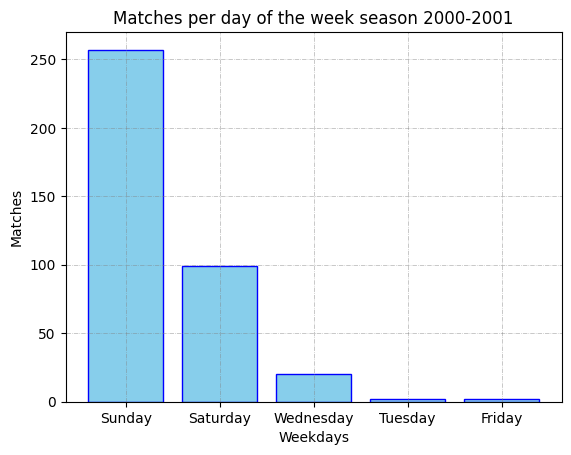

In [514]:
y = df_2000['day'].value_counts()
x = ["Sunday", "Saturday", "Wednesday", "Tuesday", "Friday"]
plt.grid(visible=True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)
plt.bar(x, y, color='skyblue', ec='blue', lw=1)
plt.title('Matches per day of the week season 2000-2001')
plt.xlabel('Weekdays')
plt.ylabel('Matches')
plt.show()


In [515]:
df_2000['time'] = pd.to_datetime(df_2000['time']).dt.strftime('%H%M%S')
df_2000['time'] = df_2000['time'].astype(int)

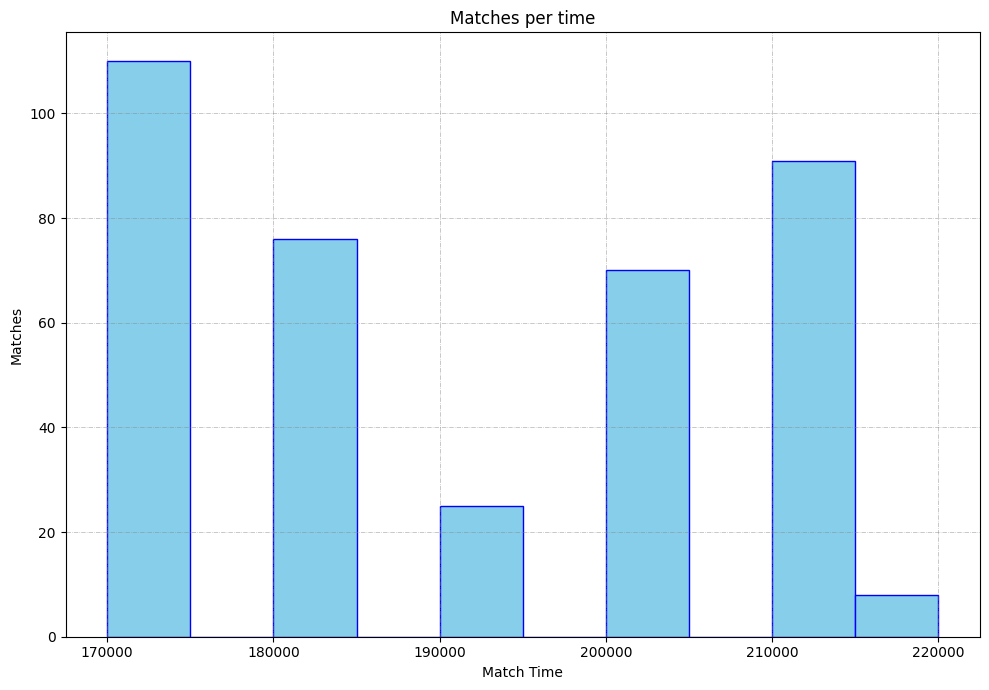

In [516]:
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
axs.grid(visible= True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

axs.hist(df_2000['time'], color = "skyblue", ec = "blue", lw = 1)
 
# Adding extra features   
plt.xlabel("Match Time")
plt.ylabel("Matches")
plt.title('Matches per time')
 
# Show plot
plt.show()

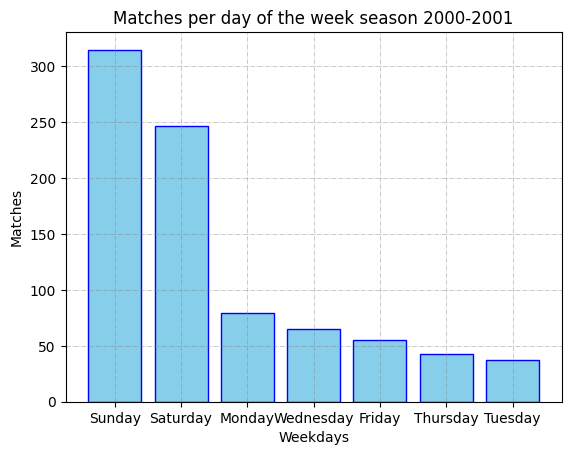

In [517]:
y = df_2021['day'].value_counts()
x = ["Sunday", "Saturday", "Monday", "Wednesday", "Friday", "Thursday", "Tuesday"]
plt.grid(visible=True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)
plt.bar(x, y, color='skyblue', ec='blue', lw=1)
plt.title('Matches per day of the week season 2000-2001')
plt.xlabel('Weekdays')
plt.ylabel('Matches')
plt.show()

In [518]:
df_2021['time'] = pd.to_datetime(df_2021['time']).dt.strftime('%H%M%S')
df_2021['time'] = df_2021['time'].astype(int)

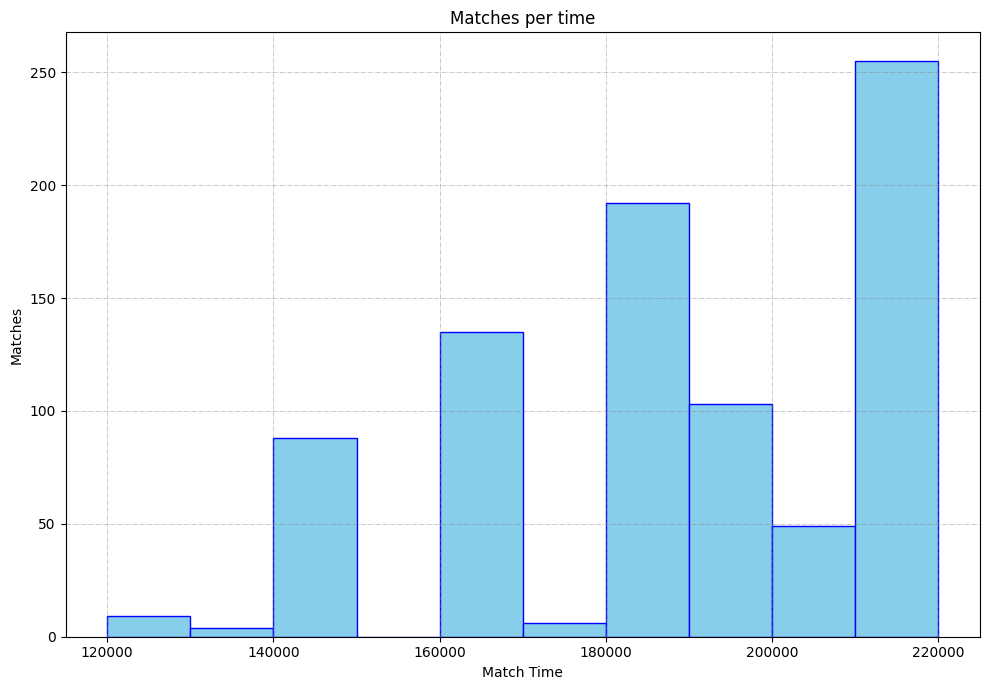

In [519]:
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
axs.grid(visible= True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

axs.hist(df_2021['time'], color = "skyblue", ec = "blue", lw = 1)
 
# Adding extra features   
plt.xlabel("Match Time")
plt.ylabel("Matches")
plt.title('Matches per time')
 
# Show plot
plt.show()

### 4. Build a cross results table for season 2020-2021 (1st division). Figure 1 is an example taken from Wikipedia. Try to make it the most similar to this one: use team abbreviations as column names and paint the background of each cell according to result (green in case local team wins and red in case visitor team wins). Also, could you model the intensity of this background color with the goal difference from the match?Write a function that, given the season and division, plots the cross results table. Function prototype should be like plot_cross_results_table(season, division) and return the plot object.

In [520]:
#import seaborn as sns
def plot_cross_resuts_table(division, season):
    division_data = df.loc[df['division'] == division].copy()
    season_data = division_data.loc[division_data['season'] == season].copy()
    laliga_crosstable = pd.crosstab(season_data['home_team'], season_data['away_team'], values=season_data['score'], aggfunc=','.join)
    #sns.heatmap(laliga_crosstable, cmap='rocket_r', annot=True, fmt='g')
    return laliga_crosstable

cross_table = plot_cross_resuts_table(1, '2020-2021')
cross_table

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,NaN,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,NaN,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,NaN,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,NaN,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,NaN,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,NaN,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,NaN,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,NaN,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,NaN,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


## 5. As you surely know, there has always been a historical rivalry between Barcelona and Real Madrid. But which of them has won the most games in direct confrontations? Which of them has scored the most goals in these games? Show both things in two pie charts, side by side. Remember to consider ties in the first one. Write a function that, given two team names, plots the two graphs described above. Function prototype should be like plot_direct_confrontations_stats(team1, team2) and return the plot object. Use it with some other classical rivals like Betis and Sevilla.

La función funciona bien y podría dejarse tal y como está. Pero podríamos intentar ver cómo hacer lo mismo con menos líneas de código.

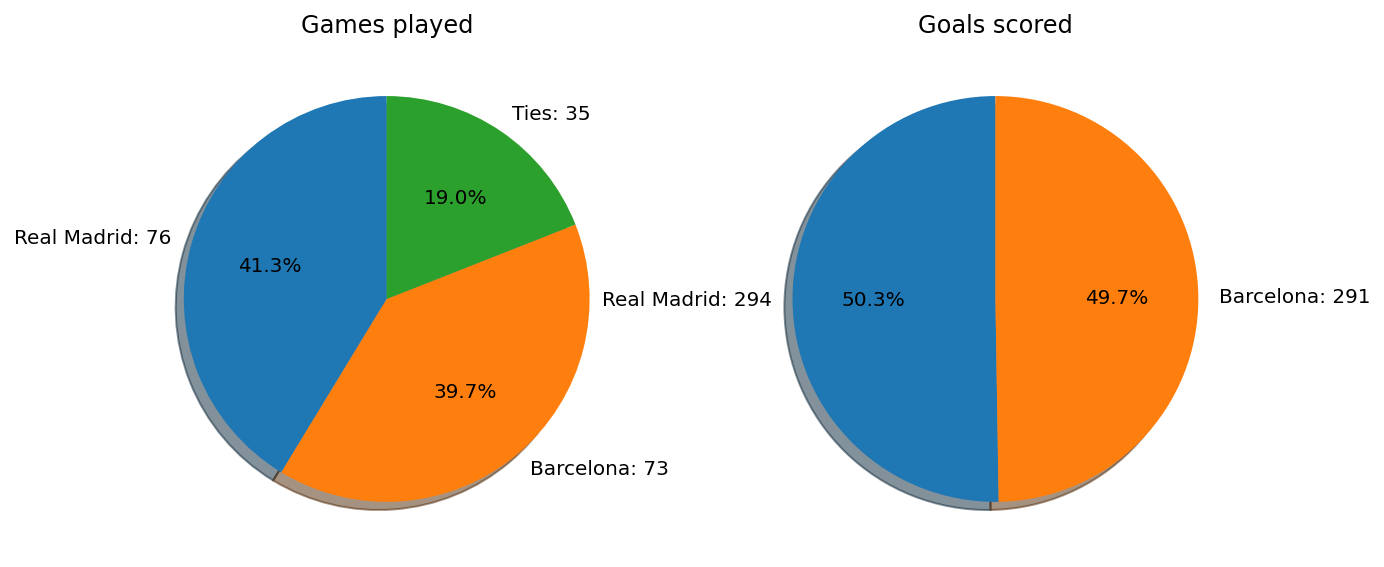

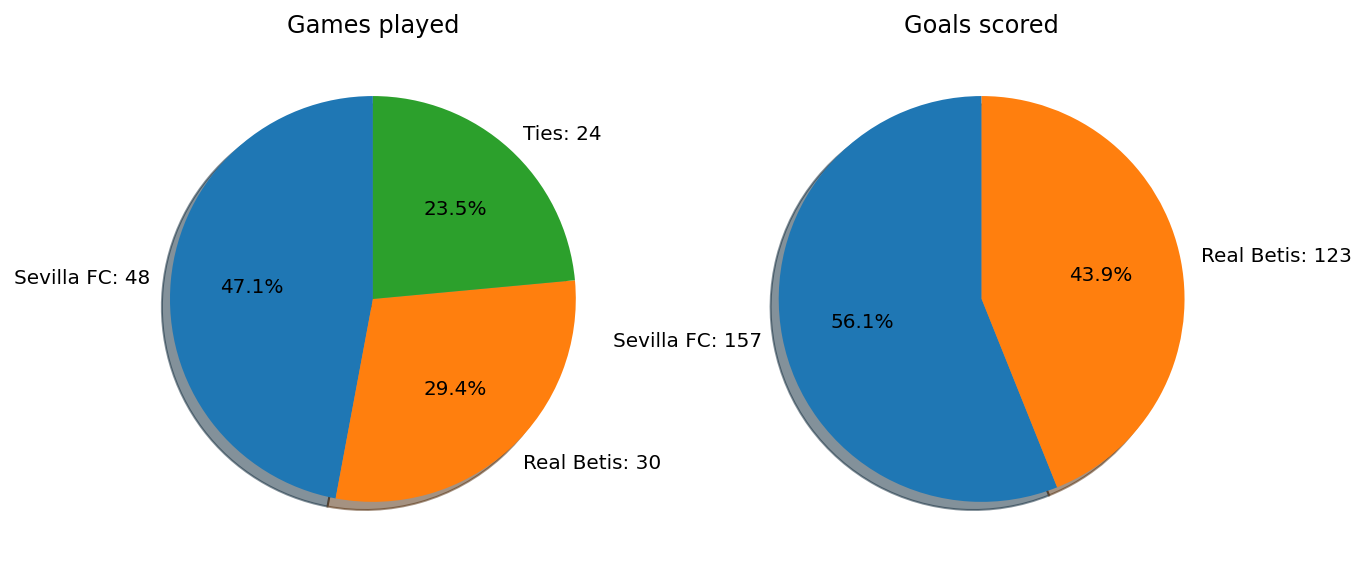

In [521]:
def plot_direct_confrontations_stats(team1, team2):
    team1_home = df.loc[df['home_team'] == team1].copy()
    team1_home = team1_home.loc[team1_home['away_team'] == team2].copy()

    team2_home = df.loc[df['home_team'] == team2].copy()
    team2_home = team2_home.loc[team2_home['away_team'] == team1].copy()

    home_goals_1 = team1_home['goals_home'].sum() # Goles team1 casa
    away_goals_1 = team2_home['goals_away'].sum() # Goles team1 fuera
    total_goals_team1 = home_goals_1 + away_goals_1

    home_goals_2 = team2_home['goals_home'].sum() # Goles team2 casa
    away_goals_2 = team1_home['goals_away'].sum() # Goles team2 fuera
    total_goals_team2 = home_goals_2 + away_goals_2

    total_wins_team1 = 0
    total_wins_team2 = 0
    total_ties = 0

    for result in team1_home['result']:
        if result == '1': total_wins_team1 += 1
        elif result == '2': total_wins_team2 += 1
        else: total_ties += 1

    for result in team2_home['result']:
        if result == '1': total_wins_team2 += 1
        elif result == '2': total_wins_team1 += 1
        else: total_ties += 1
    
    y_results = np.array([total_wins_team1, total_wins_team2, total_ties])
    y_goals   = np.array([total_goals_team1, total_goals_team2])


    label1 = team1+": "+str(total_wins_team1)
    label2 = team2+": "+str(total_wins_team2)
    label3 = "Ties: "+str(total_ties)
    label4 = team1+": "+str(total_goals_team1)
    label5 = team2+": "+str(total_goals_team2)

    mylabels_results = [label1, label2, label3]
    mylabels_goals = [label4, label5]

    fig = plt.figure(figsize=(10,7),dpi=144)

    ax1 = plt.subplot(121) #figsize =(10, 7)
    ax1.pie(y_results, labels = mylabels_results, autopct = '%1.1f%%',
            shadow = True, startangle = 90)
    ax1.set_title('Games played')

    ax2 = plt.subplot(122)
    ax2.pie(y_goals, labels = mylabels_goals, autopct = '%1.1f%%',
    shadow = True, startangle = 90)
    ax2.set_title('Goals scored')

    plt.show()

plot_direct_confrontations_stats("Real Madrid", "Barcelona")
plot_direct_confrontations_stats("Sevilla FC", "Real Betis")
    

## 6. Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the longest undefeated streaks in a horizontal bar plot, indicating in each bar the team name and the dates it held that streak, for instance, Real Sociedad 22/04/1979 - 04/05/1980.

In [522]:
df_streak = df.copy()
df_streak = df_streak.sort_values(by=['season', 'matchday'], ascending=False)
unique_teams = df_streak['home_team'].unique()

teams = []
last=datetime.date(year=1900, month=1, day=1)
for i in unique_teams:
    teams.append({'team':i, 'curr_streak':0, 'curr_ini_date':last})
streaks = pd.DataFrame(teams)
team_streaks = []

for index, row in df_streak.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    result = row['result']

    if result == '1':
        if streaks[streaks['team'] == home_team]['curr_streak'].values[0] == 0:
            streaks.loc[streaks['team'] == home_team, 'curr_ini_date'] = row['date']
        streaks.loc[streaks['team'] == home_team, 'curr_streak'] += 1
        
        if streaks[streaks['team'] == away_team]['curr_streak'].values[0] > 0:
            i_date = streaks[streaks['team'] == away_team]['curr_ini_date'].values[0]
            i_date = i_date.split('/')
            if len(i_date[0]) == 1:
                i_date[0] = '0'+i_date[0]
            if len(i_date[1]) == 1:
                i_date[1] = '0'+i_date[1]
            i_date = '/'.join(i_date)

            f_date = row['date']
            f_date = f_date.split('/')
            if len(f_date[0]) == 1:
                f_date[0] = '0'+f_date[0]
            if len(f_date[1]) == 1:
                f_date[1] = '0'+f_date[1]
            f_date = '/'.join(f_date)
            team_streaks.append({
                'team' : away_team, 
                'streak' : streaks[streaks['team'] == away_team]['curr_streak'].values[0], 
                'initial_date' : f_date,
                'ending_date' : i_date
            })
        streaks.loc[streaks['team'] == away_team, 'curr_streak'] = 0

    elif result == '2':
        if streaks[streaks['team'] == away_team]['curr_streak'].values[0] == 0:
            streaks.loc[streaks['team'] == away_team, 'curr_ini_date'] = row['date']
        streaks.loc[streaks['team'] == away_team, 'curr_streak'] += 1
        
        if streaks[streaks['team'] == home_team]['curr_streak'].values[0] > 0:
            i_date = streaks[streaks['team'] == home_team]['curr_ini_date'].values[0]
            i_date = i_date.split('/')
            if len(i_date[0]) == 1:
                i_date[0] = '0'+i_date[0]
            if len(i_date[1]) == 1:
                i_date[1] = '0'+i_date[1]
            i_date = '/'.join(i_date)

            f_date = row['date']
            f_date = f_date.split('/')
            if len(f_date[0]) == 1:
                f_date[0] = '0'+f_date[0]
            if len(f_date[1]) == 1:
                f_date[1] = '0'+f_date[1]
            f_date = '/'.join(f_date)
            team_streaks.append({
                'team' : home_team,
                'streak' : streaks[streaks['team'] == home_team]['curr_streak'].values[0],
                'initial_date' : f_date,
                'ending_date' : i_date
            })
        streaks.loc[streaks['team'] == home_team, 'curr_streak'] = 0

    elif result == 'X':
        if streaks[streaks['team'] == away_team]['curr_streak'].values[0] == 0:
            streaks.loc[streaks['team'] == away_team, 'curr_ini_date'] = row['date']
        streaks.loc[streaks['team'] == away_team, 'curr_streak'] += 1
        
        if streaks[streaks['team'] == home_team]['curr_streak'].values[0] == 0:
            streaks.loc[streaks['team'] == home_team, 'curr_ini_date'] = row['date']
        streaks.loc[streaks['team'] == home_team, 'curr_streak'] += 1

team_streaks = pd.DataFrame(team_streaks)

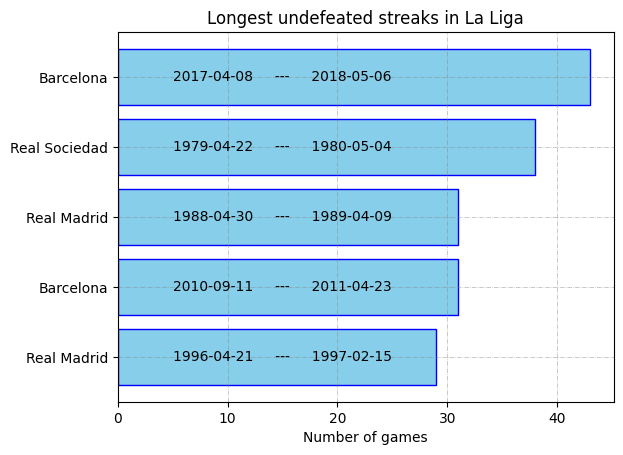

In [523]:
top_streaks = team_streaks.sort_values(by=['streak'], ascending=False)[:5].copy()

fig, ax = plt.subplots()

ax.grid(visible= True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.6)
 
teams = list(top_streaks['team'].values)
y_pos = np.arange(len(teams))
values = list(top_streaks['streak'].values)
ini_dates = list(top_streaks['initial_date'].values)
ini_dates = [datetime.datetime.strptime(i, '%m/%d/%y').date() for i in ini_dates]
end_dates = list(top_streaks['ending_date'].values)
end_dates = [datetime.datetime.strptime(i, '%m/%d/%y').date() for i in end_dates]

ax.barh(y_pos, values, align='center', color = "skyblue", ec = "blue", lw = 1)
for i, bar in enumerate(ax.patches):
    ax.text(5.0, bar.get_y()+bar.get_height()/2, str(ini_dates[i])+'     ---     '+str(end_dates[i]), color='black', ha='left', va='center')
ax.set_yticks(y_pos, labels=teams)
ax.invert_yaxis()
ax.set_xlabel('Number of games')
ax.set_title('Longest undefeated streaks in La Liga')

plt.show()

## 7.  Create a table with the final standings of each season (and division), that is, a table that contains all the teams ordered (in descending order) by the number of points they got during that season, and some other aggregate statistics. The table must contain the following columns: season, division, ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of 1st division come before standings of 2nd division. Save the final table in Excel with the name SeasonStandings.xlsx in the reports/ folder.


In [548]:
df_standings = df.copy()
points_conditions = [(df_standings['result']=='1'), (df_standings['result']=='X'), (df_standings['result']=='2')]
points_values_home = [3, 1, 0]
points_values_away = [0, 1, 3]
win_home = [1, 0, 0]
win_away = [0, 0, 1]
df_standings['points_home'] = np.select(points_conditions, points_values_home)
df_standings['points_away'] = np.select(points_conditions, points_values_away)
df_standings['win_home'] = np.select(points_conditions, win_home)
df_standings['win_away'] = np.select(points_conditions, win_away)

seasons_all = sorted(df_standings["season"].unique())
divisions_all = sorted(df_standings["division"].unique())
teams = sorted(df_standings["home_team"].unique())

all_seasons = []
for season in seasons_all:
    Data_season = df_standings.loc[df_standings["season"] == season]
    for division in sorted(Data_season['division'].unique()):
        season_standings = []
        Data_division = Data_season.loc[Data_season['division'] == division]
        for team in sorted(Data_division['home_team'].unique()):
            Data_team_home = Data_division.loc[Data_division["home_team"]==team]
            Data_team_away = Data_division.loc[Data_division["away_team"]==team]
            GF = Data_team_home['goals_home'].sum() + Data_team_away['goals_away'].sum()
            GA = Data_team_home['goals_away'].sum() + Data_team_away['goals_home'].sum()
            GD = GF - GA
            W  = Data_team_home['win_home'].sum() + Data_team_away['win_away'].sum()
            L  = Data_team_home['win_away'].sum() + Data_team_away['win_home'].sum()
            T  = len(df_standings.loc[df_standings['season'] == '2020-2021'].loc[df_standings['division']==1]['matchday'].unique()) - W - L
            Points = Data_team_home['points_home'].sum() + Data_team_away['points_away'].sum()
            season_standings.append({'Season':season, 'Division':division, 'Team':team, 'GF':GF, 'GA':GA, 'GD':GD, 'W':W, 'L':L, 'T':T, 'Pts':Points})
        season_standings = pd.DataFrame(season_standings)
        season_standings["Rank"] = season_standings[['Pts', 'GD', 'GF']].apply(tuple, axis=1).rank(method='dense',ascending=False).astype(int)
        all_seasons.append(season_standings)

all_seasons = pd.concat(all_seasons)
all_seasons = all_seasons.sort_values(by=['Season', 'Division', 'Rank'], ascending=[False, True, True])
all_seasons = all_seasons[all_seasons['Season'] != '2021-2022'].copy(deep=True)
all_seasons.reset_index(drop=True, inplace=True)
all_seasons

,Season,Division,Team,GF,GA,GD,W,L,T,Pts,Rank
0,2020-2021,1,Atlético Madrid,67,25,42,26,4,8,86,1
1,2020-2021,1,Real Madrid,67,28,39,25,4,9,84,2
2,2020-2021,1,Barcelona,85,38,47,24,7,7,79,3
3,2020-2021,1,Sevilla FC,53,33,20,24,9,5,77,4
4,2020-2021,1,Real Sociedad,59,38,21,17,10,11,62,5
...,...,...,...,...,...,...,...,...,...,...,...
2739,1928-1929,1,Athletic Madrid,43,41,2,8,8,22,26,6
2740,1928-1929,1,Espanyol,32,38,-6,7,7,24,25,7
2741,1928-1929,1,Catalunya,45,49,-4,6,8,24,22,8
2742,1928-1929,1,Real Unión,40,42,-2,5,11,22,17,9


8. Villarreal is a team that has grown a lot in recent decades. Specially ever since some billionaire guy bought it (Fernando Roig, from Mercadona). Make a line plot showing the rank of Villarreal at the end of each season, from the oldest ones (left) to the earliest ones (right). Consider rankings in 2nd division to be a continuation of the 1st one, that is, if there's N teams in 1st division and Villarreal got r position in 2nd division, then it should be placed in N + r. Draw in the same plot a line showing the cut between 1st and 2nd division. 
Write a function that, given n team names, plots the graph described above of each one of them superposed. Function prototype should be like plot_ranking_evolution(team1, team2, ..., teamN) and return the plot ob- ject (note that function should not take one array-type argument, but n arguments). Use it to compare the evolution of all the teams that currently play in 1st division.

In [ ]:
type(all_seasons)

In [621]:
diego = all_seasons.copy()
villarreal = diego.loc[diego['Team'] == 'Villarreal']
seasons = villarreal['Season'].unique()
print(seasons)
y = (villarreal['Rank'] + 20*(villarreal['Division']-1))
x = np.array(villarreal['Season'])
# plt.plot(x, y)
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
# plt.show()
#a = df.loc[df['season']=='2020-2021']
#len(a.loc[a['division']==1]['home_team'].unique())
# def caca(*listas):
#     y = []
#     x = []
#     for lista in listas:
        

# y1 = [1, 2, 4]
# y = []
# y.append(y1)
# print(y)

['2020-2021' '2019-2020' '2018-2019' '2017-2018' '2016-2017' '2015-2016'
 '2014-2015' '2013-2014' '2012-2013' '2011-2012' '2010-2011' '2009-2010'
 '2008-2009' '2007-2008' '2006-2007' '2005-2006' '2004-2005' '2003-2004'
 '2002-2003' '2001-2002' '2000-2001' '1999-2000' '1998-1999' '1997-1998'
 '1996-1997' '1995-1996' '1994-1995' '1993-1994' '1992-1993' '1971-1972'
 '1970-1971']


## 9. In football jargon, those teams that are permanently descending and ascending between 1st and 2nd division are called elevator teams. What are the most elevator teams in LaLiga? Plot the history of the top 5 of them using the function from exercise 9.

In [639]:
df_elevators = df.copy()
#df_elevators = df_elevators.loc[df_elevators['division']]
x = 0

for team in sorted(df_elevators['home_team'].unique()):
    team_elevator = df_elevators.loc[df_elevators['home_team'] == team]
    team_division = []
    for season in sorted(team_elevator['season'].unique()):
        team_division = team_division.append(team_elevator[])
# for season in df_elevators['season'].unique():
#     for team in df_elevators.loc[df_elevators['season']==season]['home_team']:
#         print(team)
# seasons_all = sorted(df_elevators["season"].unique())
# divisions_all = sorted(seasons_all["division"].unique())
# teams = sorted(divisions_all["home_team"].unique())
# print(division_all)

#np.where(df_elevators['division'] == 2)

# for season in seasons_all:
#     print(len(df_elevators.loc[df_elevators['season']==season]['division'].unique()) > 1)
    
a1 = df_elevators.loc[df_elevators['season']=='1942-1943'] # hay segunda
a2 = df_elevators.loc[df_elevators['season']=='1943-1944'] # no hay segunda
a3 = df_elevators.loc[df_elevators['season']=='1944-1945'] # sí hay segunda

# print(sorted(a1.loc[a1['division']==1]['home_team'].unique()))
# print(sorted(a1.loc[a1['division']==2]['home_team'].unique()))
# print("\n")
# print(sorted(a2.loc[a2['division']==1]['home_team'].unique()))
# print("\n")
# print(sorted(a3.loc[a3['division']==1]['home_team'].unique()))
# print(sorted(a3.loc[a3['division']==2]['home_team'].unique()))

TypeError: array() missing required argument 'object' (pos 0)

### 10. Create a table that is the same as the one in exercise 7, but not only with the season final standings, but the standings at the end of each matchday. Columns are the same, including matchday that tells about which matchday from the season these standings are from. Would you be able to add a new column last_5 with the result of last 5 matches? This column should contain a list like ["W", "L", "W", "T", "T"]. In this list, the first item is the immediate previous match, the second one is the match before this one, and so on. If there are no 5 previous matches (because matchday < 6, for instance) then just make the list shorter. Save the final table in Excel with the name MatchdayStandings.xlsx in the reports/ folder.

### 10. Create a table that is the same as the one in exercise 7, but not only with the season final standings, but the standings at the end of each matchday. Columns are the same, including matchday that tells about which matchday from the season these standings are from. Would you be able to add a new column last_5 with the result of last 5 matches? This column should contain a list like ["W", "L", "W", "T", "T"]. In this list, the first item is the immediate previous match, the second one is the match before this one, and so on. If there are no 5 previous matches (because matchday < 6, for instance) then just make the list shorter. Save the final table in Excel with the name MatchdayStandings.xlsx in the reports/ folder.

### 10. Create a table that is the same as the one in exercise 7, but not only with the season final standings, but the standings at the end of each matchday. Columns are the same, including matchday that tells about which matchday from the season these standings are from. Would you be able to add a new column last_5 with the result of last 5 matches? This column should contain a list like ["W", "L", "W", "T", "T"]. In this list, the first item is the immediate previous match, the second one is the match before this one, and so on. If there are no 5 previous matches (because matchday < 6, for instance) then just make the list shorter. Save the final table in Excel with the name MatchdayStandings.xlsx in the reports/ folder.